In [ ]:
!pip install transformers datasets wandb scikit-learn imbalanced-learn nlpaug accelerate
from google.colab import drive
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoModelForSequenceClassification, AutoTokenizer,  TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
drive.mount('/content/drive')

import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import wandb
import zipfile

torch.manual_seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.5 MB/s eta 0:00:00


Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/polarization_dataset.zip'
extract_path = '/content/drive/MyDrive/polarization_dataset/'

if os.path.exists(extract_path) and len(os.listdir(extract_path)) > 0:
    print("Dataset already exists and is extracted. Skipping download.")
else:
    print("Dataset not found. Downloading...")
    !wget -O "{dataset_path}" "https://www.codabench.org/datasets/download/1c1791a1-a41b-4895-a636-49fb7234cb48/"
    print("Download complete. Extracting...")

    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"Dataset extracted to: {extract_path}")

Dataset already exists and is extracted. Skipping download.


# SUBTASK 1 ENGLISH


## Data Loading and Exploratory Data Analysis (EDA)

In [ ]:
print("Contents of subtask1:")
!ls polarization_dataset/subtask1/

# Load train.csv or similar
# train_path = 'polarization_dataset/subtask1/train/eng.csv'  # adjust if needed
train_path = '/content/drive/MyDrive/polarization_dataset/subtask1/train/eng.csv'  # adjust if needed
if os.path.exists(train_path):
    df = pd.read_csv(train_path)
    print(f"Loaded {len(df)} samples from {train_path}")
    print(df.head())
else:
    print("Train file not found, listing all files:")
    !find polarization_dataset/ -name "*.csv"

Contents of subtask1:
ls: cannot access 'polarization_dataset/subtask1/': No such file or directory
Loaded 3222 samples from /content/drive/MyDrive/polarization_dataset/subtask1/train/eng.csv
                                     id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  polarization  
0           is defending imperialism in the dnd chat             0  
1  Still playing with this. I am now following Ra...             0  
2  .senate.gov Theres 3 groups out there Republic...             0  
3  "ABC MD, David Anderson, said the additional f...             0  
4  "bad people" I have some conservative values s...             0  



Train class distribution:
polarization
0    0.63532
1    0.36468
Name: proportion, dtype: float64

Train text length stats:
count    3222.000000
mean       74.777778
std        47.385309
min        18.000000
25%        46.000000
50%        58.000000
75%        89.750000
max       299.000000
Name: text_length, dtype: float64

Dev text length stats:


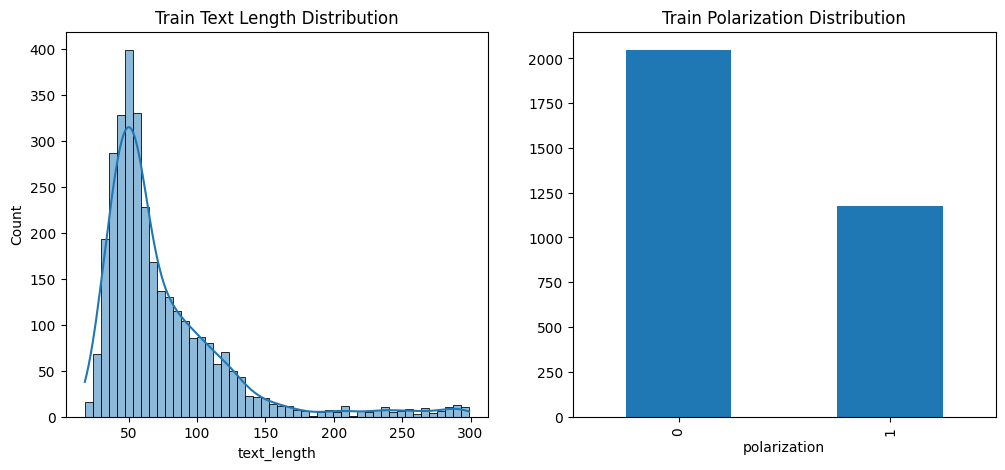

In [ ]:


# Class distribution
print("\nTrain class distribution:")
print(df['polarization'].value_counts(normalize=True))

# Note: Dev set appears to be unlabeled (polarization is NaN), likely the test set.

# Text length analysis
df['text_length'] = df['text'].apply(len)

print("\nTrain text length stats:")
print(df['text_length'].describe())

print("\nDev text length stats:")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['text_length'], ax=axes[0], kde=True)
axes[0].set_title('Train Text Length Distribution')


# Class balance plot for train
# plt.figure(figsize=(6, 4))
df['polarization'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Train Polarization Distribution')
plt.show()

## Data Preprocessing

In [ ]:


# Text cleaning function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags but keep the word
    text = re.sub(r'#', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Lowercase
    text = text.lower()
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Split train into train and val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['polarization'], random_state=42)
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

# Create datasets
train_dataset = Dataset.from_pandas(train_df[['clean_text', 'polarization']].rename(columns={'clean_text': 'text'}))
val_dataset = Dataset.from_pandas(val_df[['clean_text', 'polarization']].rename(columns={'clean_text': 'text'}))

# Tokenizer
model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
    tokenized['labels'] = examples['polarization']
    return tokenized

# Tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Preprocessing complete.")

Train size: 2577, Val size: 645


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Preprocessing complete.


## Model Architecture and Training

In [ ]:

# W&B setup
wandb.init(project='polarization-detection', name='deberta-v3-base-run')

# Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['polarization']), y=train_df['polarization'])
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class weights: {class_weights}")

# Compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average='macro')
    return {'f1': f1}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1', # Changed from 'eval_f1_macro' to 'eval_f1'
    greater_is_better=True,
    report_to='wandb',
    seed=42,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train
trainer.train()

# Save model
trainer.save_model('./best_model')
wandb.finish()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

KeyboardInterrupt



## Evaluation and Submission

In [ ]:
# Load the best model from training

model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load best model (assuming it was saved during training)
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/best_model')

# Set model to eval mode
model.eval()

# Prepare dev dataset for prediction
import pandas as pd
from datasets import Dataset
import re

# Text cleaning function (same as before)
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# Load dev data
dev_path = 'polarization_dataset/subtask1/dev/eng.csv'
df_dev = pd.read_csv(dev_path)
df_dev['clean_text'] = df_dev['text'].apply(clean_text)
print(df_dev.head())

In [ ]:

# Create dataset
dev_dataset = Dataset.from_pandas(df_dev[['clean_text']].rename(columns={'clean_text': 'text'}))
dev_dataset = dev_dataset.map(lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Predict
from torch.utils.data import DataLoader
dataloader = DataLoader(dev_dataset, batch_size=8)

predictions = []
with torch.no_grad():
    for batch in dataloader:
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Create submission
submission = df_dev[['id']].copy()
submission['polarization'] = predictions
submission.to_csv('submission.csv', index=False)

print("Submission generated and saved to submission.csv")
print(f"Predicted class distribution: {pd.Series(predictions).value_counts()}")
print(submission.head())

In [ ]:
model.save_pretrained('./final_model')
tokenizer.save_pretrained('./final_model')

print("Model and tokenizer saved to './final_model'")

# Zip the model for easy download/sharing
!zip -r final_model.zip ./final_model
print("Model zipped as final_model.zip")

# To save to Google Drive (if using Colab)
# !cp final_model.zip /content/drive/MyDrive/

print("Ready for download or sharing!")

# SUBTASK 1 SWAHILI

In [ ]:

print("Contents of subtask1:")
!ls /content/drive/MyDrive/polarization_dataset/subtask1/

train_path_hau = '/content/drive/MyDrive/polarization_dataset/subtask1/train/swa.csv'
if os.path.exists(train_path_hau):
    df_swa = pd.read_csv(train_path_hau)
    print(f"Loaded {len(df_swa)} samples from {train_path_hau}")
    # print(df_swa.head())
else:
    print("Hausa train file not found, listing all files:")
    !find polarization_dataset/subtask2/ -name "*.csv"

Contents of subtask1:
dev  train
Loaded 6991 samples from /content/drive/MyDrive/polarization_dataset/subtask1/train/swa.csv



Swahili Train class distribution:
polarization
1    0.501216
0    0.498784
Name: proportion, dtype: float64

Swahili Train text length stats:
count    6991.000000
mean       79.679302
std        38.659574
min        14.000000
25%        49.000000
50%        74.000000
75%       104.000000
max       400.000000
Name: text_length, dtype: float64


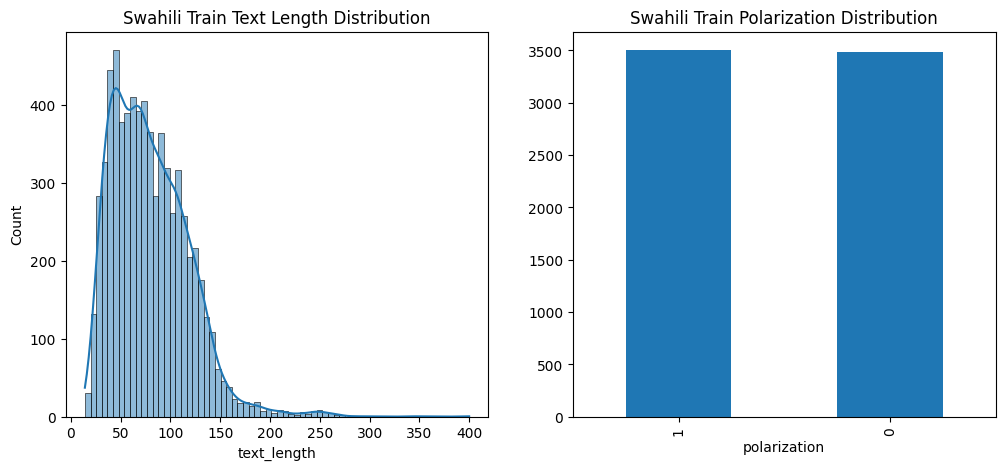

In [ ]:


# Class distribution
print("\nSwahili Train class distribution:")
print(df_swa['polarization'].value_counts(normalize=True))

# Text length analysis
df_swa['text_length'] = df_swa['text'].apply(len)

print("\nSwahili Train text length stats:")
print(df_swa['text_length'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_swa['text_length'], ax=axes[0], kde=True)
axes[0].set_title('Swahili Train Text Length Distribution')

# Class balance plot
df_swa['polarization'].value_counts().plot(kind='bar', ax= axes[1])
axes[1].set_title('Swahili Train Polarization Distribution')
plt.show()

In [ ]:
def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

df_swa['clean_text'] = df_swa['text'].apply(clean_text)

train_df_swa, val_df_swa = train_test_split(df_swa, test_size=0.2, stratify=df_swa['polarization'], random_state=42)
print(f"Swahili Train size: {len(train_df_swa)}, Val size: {len(val_df_swa)}")

train_dataset_swa = Dataset.from_pandas(train_df_swa[['clean_text', 'polarization']].rename(columns={'clean_text': 'text'}))
val_dataset_swa = Dataset.from_pandas(val_df_swa[['clean_text', 'polarization']].rename(columns={'clean_text': 'text'}))

model_name_swa = 'xlm-roberta-base'
tokenizer_swa = AutoTokenizer.from_pretrained(model_name_swa)

# Tokenize
def tokenize_function(examples):
    tokenized = tokenizer_swa(examples['text'], truncation=True, padding='max_length', max_length=128)
    tokenized['labels'] = examples['polarization']
    return tokenized

train_dataset_swa = train_dataset_swa.map(tokenize_function, batched=True)
val_dataset_swa = val_dataset_swa.map(tokenize_function, batched=True)

train_dataset_swa.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_swa.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Swahili preprocessing complete.")

In [ ]:
wandb.init(project='polarization-detection', name='xlm-roberta-base-swa-run-train-size-5592')

model_swa = AutoModelForSequenceClassification.from_pretrained(model_name_swa, num_labels=2, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
# model_swa = AutoModelForSequenceClassification.from_pretrained(model_name_swa, num_labels=2, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predictions, average='macro')
    return {'f1': f1}


training_args_swa = TrainingArguments(
    output_dir='./results_swa',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs_swa',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    report_to='wandb',
    seed=42,
)

trainer_swa = Trainer(
    model=model_swa,
    args=training_args_swa,
    train_dataset=train_dataset_swa,
    eval_dataset=val_dataset_swa,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer_swa.train()


In [ ]:
trainer_swa.save_model('/content/drive/MyDrive/best_model_swa_train_5592_3')
wandb.finish()

In [ ]:
df_dev_swa = df_dev_swa.drop(columns=['text_length'])
df_dev_swa.head()

In [ ]:
df_dev_swa['clean_text'] = df_dev_swa['text'].apply(clean_text)

# Create dataset
dev_dataset = Dataset.from_pandas(df_dev_swa[['clean_text']].rename(columns={'clean_text': 'text'}))
dev_dataset = dev_dataset.map(lambda x: tokenizer_swa(x['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Predict
from torch.utils.data import DataLoader

dataloader = DataLoader(dev_dataset, batch_size=8)

# Move model to appropriate device (if not already moved by Trainer)
# This is crucial for inference outside the Trainer loop.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_swa.to(device)

predictions = []
with torch.no_grad():
    for batch in dataloader:
        # Move batch to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_swa(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Create submission
submission = df_dev_swa[['id']].copy()
submission['polarization'] = predictions
submission.to_csv('pred_swa.csv', index=False)

print("Submission generated and saved to pred_swa.csv")
print(f"Predicted class distribution: {pd.Series(predictions).value_counts()}")
print(submission.head())

In [ ]:
# Load Subtask 2 data for English

train_path_sub2_swa = '/content/drive/MyDrive/polarization_dataset/subtask2/train/swa.csv'
if os.path.exists(train_path_sub2_swa):
    df_sub2_swa = pd.read_csv(train_path_sub2_swa)
    print(f"Loaded {len(df_sub2_swa)} samples from {train_path_sub2_swa}")
else:
    print("Subtask 2 train file not found")

# Labels
labels = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
df_sub2_swa[labels] = df_sub2_swa[labels].astype(int)
df_sub2_swa.tail(5)

In [ ]:
if 'df_sub2_swa' in locals():
    # Class distribution: Calculate percentage of positive labels for each category
    print("Class distribution (percentage of positive labels):")
    for label in labels:
        pos_count = df_sub2_swa[label].sum()
        total = len(df_sub2_swa)
        percentage = (pos_count / total) * 100
        print(f"{label}: {pos_count} positive ({percentage:.2f}%)")

    # Imbalance severity: Identify which labels are most imbalanced
    print("\nImbalance severity (sorted by positive percentage):")
    imbalance = {}
    for label in labels:
        pos_pct = (df_sub2_swa[label].sum() / len(df_sub2_swa)) * 100
        imbalance[label] = pos_pct
    sorted_imbalance = sorted(imbalance.items(), key=lambda x: x[1])
    for label, pct in sorted_imbalance:
        print(f"{label}: {pct:.2f}% positive")

    # Label co-occurrence matrix: Which labels appear together?
    print("\nLabel co-occurrence matrix:")
    co_occurrence = df_sub2_swa[labels].T.dot(df_sub2_swa[labels])
    print(co_occurrence)

    # Correlation analysis: Compute correlation between labels
    print("\nLabel correlation matrix:")
    correlation = df_sub2_swa[labels].corr()
    print(correlation)

    # Visualization: Class distribution bar chart
    plt.figure(figsize=(10, 6))
    pos_counts = [df_sub2_swa[label].sum() for label in labels]
    plt.bar(labels, pos_counts)
    plt.title('Positive Label Counts per Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Label co-occurrence heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(co_occurrence, annot=True, cmap='Blues', fmt='d')
    plt.title('Label Co-occurrence Matrix')
    plt.show()

#

# Subtask 2 Exploratory Data Exploration

## English

In [ ]:
df  = pd.read_csv("/content/drive/MyDrive/polarization_dataset/subtask2/train/eng.csv")
#

In [ ]:
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMemory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Shape: (3222, 7)

Columns: ['id', 'text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

Data types:
id               object
text             object
political         int64
racial/ethnic     int64
religious         int64
gender/sexual     int64
other             int64
dtype: object

Memory: 0.77 MB


In [ ]:
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicates: {df.duplicated().sum()}")
print(f"Unique IDs: {df['id'].nunique()}")


Missing values:
id               0
text             0
political        0
racial/ethnic    0
religious        0
gender/sexual    0
other            0
dtype: int64

Duplicates: 0
Unique IDs: 3222


In [ ]:
# 3. TEXT ANALYSIS
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
print(f"\nText length - Min: {df['text_length'].min()}, Max: {df['text_length'].max()}, Mean: {df['text_length'].mean():.1f}")
print(f"Word count - Min: {df['word_count'].min()}, Max: {df['word_count'].max()}, Mean: {df['word_count'].mean():.1f}")


Text length - Min: 18, Max: 299, Mean: 74.8
Word count - Min: 4, Max: 60, Mean: 12.3


In [ ]:
# 4. LABEL DISTRIBUTION
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
print(f"\nLabel distribution:")
for col in label_cols:
    count = df[col].sum()
    pct = (count / len(df)) * 100
    print(f"  {col}: {count} ({pct:.2f}%)")


Label distribution:
  political: 1150 (35.69%)
  racial/ethnic: 281 (8.72%)
  religious: 112 (3.48%)
  gender/sexual: 72 (2.23%)
  other: 126 (3.91%)


In [ ]:
total = len(df)
print(total)

3222


*63.5% of your data has no labels - most texts are clean. Of the labeled data, political dominates at 35.69% while the other four categories are starved (all under 9%). Total = 3222, Non labelled = 2047*
Damn that's really a whole lot mheen



💭 : should be able to consider this multilabel problem as a single labelled problem initially of positive or negative. I can use an equal amount of data with all labels set to zero, and all data with at least a label set to one.

For subtask, treat as a positive or negative task first. Then focus on the "Negative" subspace. Talk in terms of probabilities:

Pr( "Political"  | Polarization ) =   (% of polarization in entire dataset) * ( % of polarized examples that are political)


For the negatives, generate a heatmap to show correlation.
try and show the conditional probabilities of the co occurence. this makes it easily to get P( A and B | polarized ) = (Number of A and B co-occuring)/Number of polarized examples.

Class imbalance occurs when one class (the majority class) has significantly more examples than another class (the minority class) in your dataset. In your case with hate speech detection, this means you likely have far more non-toxic texts (labeled 0) than toxic texts (labeled 1) across your five categories.​

The Problem
When classes are imbalanced, machine learning models tend to become biased toward the majority class. For example, if 95% of your texts have political=0 (no political hate speech) and only 5% have political=1, a model could achieve 95% accuracy by simply predicting 0 for everything—but it would completely fail at detecting actual political hate speech.

https://www.sciencedirect.com/topics/computer-science/class-imbalance

In [ ]:
# 5. MULTI-LABEL ANALYSIS
df['label_count'] = df[label_cols].sum(axis=1)
print(f"\nRows with no labels: {(df['label_count'] == 0).sum()}")
print(f"Rows with 1 label: {(df['label_count'] == 1).sum()}")
print(f"Rows with 2+ labels: {(df['label_count'] >= 2).sum()}")
print(f"\nLabel count distribution:\n{df['label_count'].value_counts().sort_index()}")


Rows with no labels: 2047
Rows with 1 label: 749
Rows with 2+ labels: 426

Label count distribution:
label_count
0    2047
1     749
2     299
3     115
4      11
5       1
Name: count, dtype: int64


In [ ]:
# 7. CLASS IMBALANCE
total = len(df)
for col in label_cols:
    pos = df[col].sum()
    neg = total - pos
    ratio = neg / pos if pos > 0 else float('inf')
    print(f"{col} - Imbalance ratio: {ratio:.2f}:1")

political - Imbalance ratio: 1.80:1
racial/ethnic - Imbalance ratio: 10.47:1
religious - Imbalance ratio: 27.77:1
gender/sexual - Imbalance ratio: 43.75:1
other - Imbalance ratio: 24.57:1


In [ ]:

# Define label columns
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

# Filter: Keep only rows where at least one label = 1
df_labeled = df[df[label_cols].sum(axis=1) > 0]

print(f"Original dataset: {len(df)} rows")
print(f"Filtered dataset: {len(df_labeled)} rows ({len(df_labeled)/len(df)*100:.1f}%)")
print(f"Removed: {len(df) - len(df_labeled)} rows with no labels")

# Save filtered dataset
# df_labeled.to_csv('labeled_only.csv', index=False)
# print("\nSaved to: labeled_only.csv")


Original dataset: 3222 rows
Filtered dataset: 1175 rows (36.5%)
Removed: 2047 rows with no labels


In [ ]:

print(f"\nLabel correlations:\n{df[label_cols].corr()}")
print(f"\nLabel correlations:\n{df_labeled[label_cols].corr()}")


Label correlations:
               political  racial/ethnic  religious  gender/sexual     other
political       1.000000       0.387355   0.226434       0.185403  0.250737
racial/ethnic   0.387355       1.000000   0.403750       0.109555  0.107882
religious       0.226434       0.403750   1.000000       0.063017  0.049124
gender/sexual   0.185403       0.109555   0.063017       1.000000  0.110319
other           0.250737       0.107882   0.049124       0.110319  1.000000

Label correlations:
               political  racial/ethnic  religious  gender/sexual     other
political       1.000000      -0.083250  -0.112810      -0.060691 -0.063266
racial/ethnic  -0.083250       1.000000   0.341174       0.031456 -0.000856
religious      -0.112810       0.341174   1.000000       0.013740 -0.018829
gender/sexual  -0.060691       0.031456   0.013740       1.000000  0.060545
other          -0.063266      -0.000856  -0.018829       0.060545  1.000000


**The Key Difference**
_Full dataset (with 0s): All correlations are positive because categories are mostly absent together - they share the same zeros.​_

Labeled-only dataset (toxic content only): Reveals actual hate speech patterns:​

Critical Finding
Political hate is MUTUALLY EXCLUSIVE from other types:

Political vs racial/ethnic: -0.083 (negative correlation)

Political vs religious: -0.113 (negative correlation)​

This means: When political hate speech appears, other types rarely do. Political toxicity is a separate beast.​

What Co-Occurs
Racial/ethnic and religious: +0.341 - These two types genuinely overlap in toxic content. When someone expresses racial hate, there's a 34% tendency to also express religious hate.​

Bottom Line
Your hate speech has two distinct clusters:​

Political hate - stands alone (your 35.69% is mostly single-label)

Identity-based hate - racial/ethnic and religious co-occur together

This explains why 64% of your labeled samples have only 1 label - hate speech specializes by domain, it doesn't blend

**Interpretation **
Multi-Label Pattern
36% of toxic texts have multiple labels, indicating hate speech often spans categories. This makes the minority class problem worse - models need even more examples to learn combinations.​

Action Required
You need to oversample or augment religious, gender/sexual, and other categories before training, or your model will ignore them entirely and just predict political hate speech. Consider collecting more minority class examples or using techniques like SMOTE, class weights, or focal loss to compensate.​


Label correlations:
               political  racial/ethnic  religious  gender/sexual     other
political       1.000000       0.387355   0.226434       0.185403  0.250737
racial/ethnic   0.387355       1.000000   0.403750       0.109555  0.107882
religious       0.226434       0.403750   1.000000       0.063017  0.049124
gender/sexual   0.185403       0.109555   0.063017       1.000000  0.110319
other           0.250737       0.107882   0.049124       0.110319  1.000000


### Generative AI
**Minority class** = the class with **fewer examples** that you actually care about detecting.[1][2]

## In Your Data

For each category, you have two classes:
- **Majority class (label=0)**: Texts WITHOUT that type of hate speech - abundant
- **Minority class (label=1)**: Texts WITH that type of hate speech - rare and what you want to detect[3]

## Concrete Example from Your Results

**Gender/sexual category:**
- Minority class (label=1): 72 toxic texts
- Majority class (label=0): 3,150 clean texts
- Ratio: 43.75:1[1]

The minority class is **what matters most** - those 72 examples of gender/sexual hate speech are what you're trying to catch. But with so few examples, your model will struggle to learn the patterns and will likely just predict everything as 0 (clean).[2][4]

## Why "Minority" Matters

In problems like fraud detection, medical diagnosis, or hate speech detection, the **rare event is the important one**. You don't care much about correctly identifying the 99% of normal transactions - you care about catching that 1% of fraud. That's why the minority class (the positive/rare case) gets special attention and requires techniques like oversampling or class weights to compensate for its scarcity.[5][4][3][1]

[1](https://www.sciencedirect.com/topics/computer-science/minority-class)
[2](https://www.machinelearningmastery.com/what-is-imbalanced-classification/)
[3](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets)
[4](https://www.knime.com/blog/correcting-predicted-class-probabilities-in-imbalanced-datasets)
[5](https://www.blog.trainindata.com/oversampling-techniques-for-imbalanced-data/)
[6](https://encord.com/glossary/class-imbalance-definition/)
[7](https://isi-web.org/sites/default/files/2024-02/Handling-Data-Imbalance-in-Machine-Learning.pdf)
[8](https://stackoverflow.com/questions/75049415/in-imbalanced-datasets-the-positive-class-is-the-majority-class)
[9](https://www.opporture.org/lexicon/majority-class/)
[10](https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/)

##

In [ ]:
TITLE_SIZE = 20
AXIS_LABEL_SIZE = 20
TICK_LABEL_SIZE = 20
LINE_MARKER_SIZE = 8

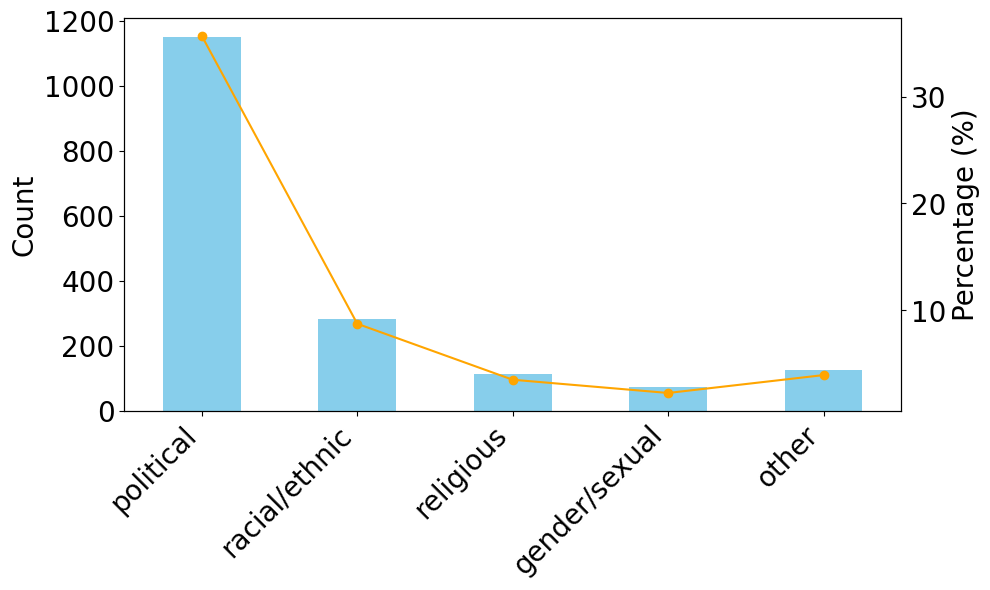

political        35.692117
racial/ethnic     8.721291
religious         3.476102
gender/sexual     2.234637
other             3.910615
dtype: float64


In [ ]:

from google.colab import files  # For downloading in Colab

# Load the dataset (assuming you're running in Colab with Drive mounted)
df = pd.read_csv("/content/drive/MyDrive/polarization_dataset/subtask2/train/eng.csv")

# Define label columns
label_cols = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

# 1. Bar chart for label distribution (counts and percentages)
label_counts = df[label_cols].sum()
label_pcts = (label_counts / len(df)) * 100

fig1, ax1 = plt.subplots(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue', ax=ax1)
# ax1.set_title('Label Distribution (Counts)')
ax1.set_ylabel('Count', fontsize=AXIS_LABEL_SIZE)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=TICK_LABEL_SIZE, rotation=45, ha='right')
ax1.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)

# Twin axis for percentages
ax2 = ax1.twinx()
label_pcts.plot(kind='line', color='orange', marker='o', ax=ax2)
ax2.set_ylabel('Percentage (%)', fontsize=AXIS_LABEL_SIZE)
ax2.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)

plt.tight_layout()

plt.show()

print(label_pcts)

# Save as SVG
# fig1.savefig('subtask2_label_distribution.pdf', format='pdf')

In [ ]:
all_zero_rows = (df[label_cols].sum(axis=1) == 0).sum()
print(all_zero_rows)

2047


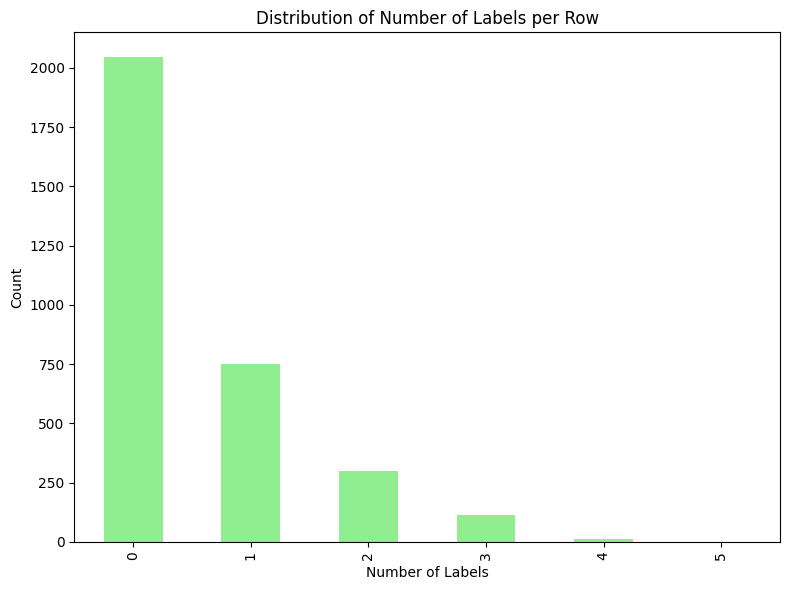

In [ ]:
# 2. Pie chart or bar for multi-label count distribution
multi_label_counts = df[label_cols].sum(axis=1).value_counts().sort_index()

fig2, ax = plt.subplots(figsize=(8, 6))
multi_label_counts.plot(kind='bar', color='lightgreen')
ax.set_title('Distribution of Number of Labels per Row')
ax.set_xlabel('Number of Labels')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Save as SVG
fig2.savefig('multi_label_distribution.svg', format='svg')

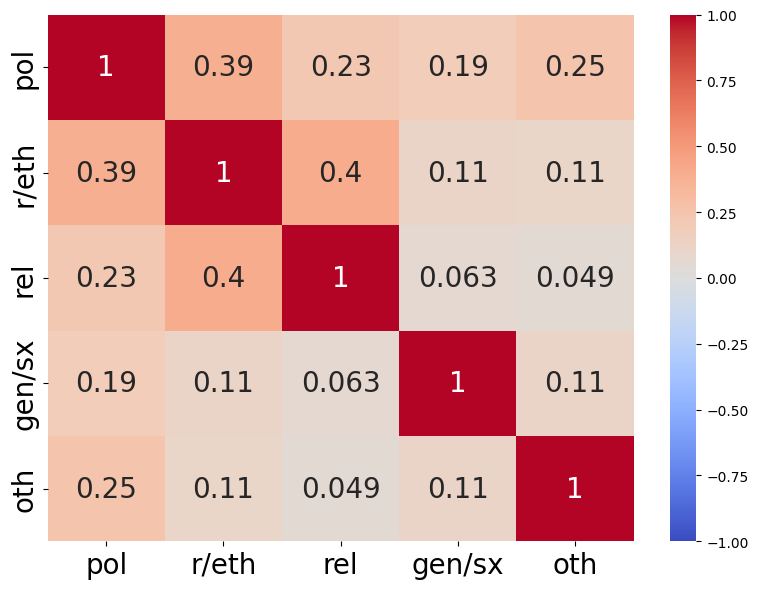

In [ ]:
# 3. Heatmap for label correlations (full dataset)

corr_matrix = df[label_cols].corr()

# Define display labels (in the same order as label_cols)
display_labels = ['pol', 'r/eth', 'rel', 'gen/sx', 'oth']

# Rename rows and columns for visualization
corr_matrix.index = display_labels
corr_matrix.columns = display_labels

fig3, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    ax=ax,
    annot_kws={"size": TICK_LABEL_SIZE}
)

# Axis tick label sizes
ax.tick_params(axis='both', labelsize=TICK_LABEL_SIZE)

# Axis labels (kept empty for cleanliness)
ax.set_xlabel('', fontsize=AXIS_LABEL_SIZE)
ax.set_ylabel('', fontsize=AXIS_LABEL_SIZE)

plt.tight_layout()
plt.show()

# Save as PDF
fig3.savefig('subtask2_label_correlations.pdf', format='pdf')


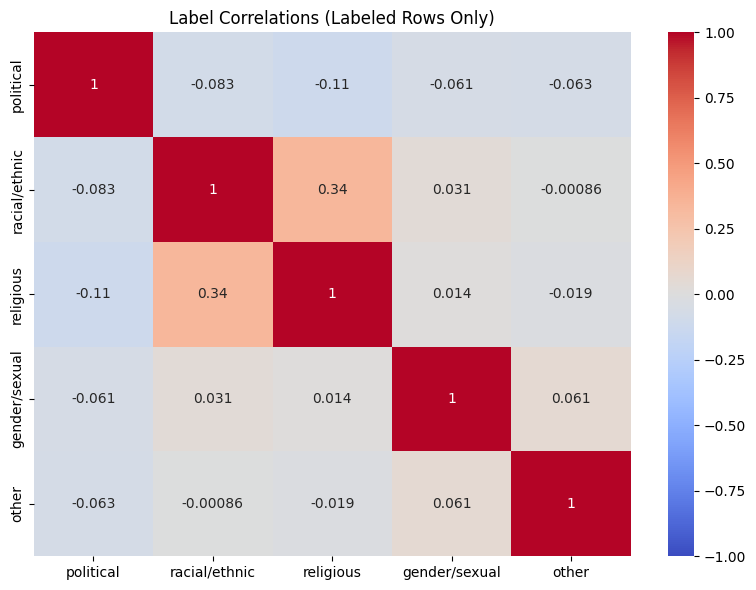

In [ ]:
# 4. Heatmap for label correlations (labeled only)
df_labeled = df[df[label_cols].sum(axis=1) > 0]
corr_matrix_labeled = df_labeled[label_cols].corr()

fig4, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix_labeled, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
ax.set_title('Label Correlations (Labeled Rows Only)')
plt.tight_layout()
plt.show()

# Save as SVG
fig4.savefig('subtask_label_correlations_labeled.svg', format='svg')

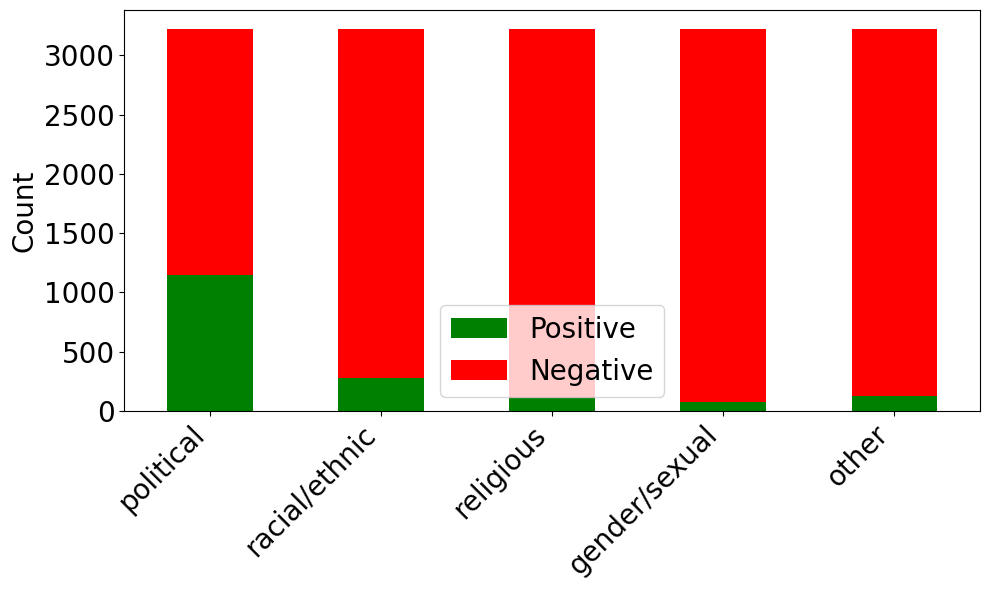

In [ ]:
# 5. Stacked bar for class imbalance visualization
imbalance_data = pd.DataFrame({
    'Positive': df[label_cols].sum(),
    'Negative': len(df) - df[label_cols].sum()
})

fig5, ax = plt.subplots(figsize=(10, 6))

imbalance_data.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],
    ax=ax
)

# Axis labels
ax.set_ylabel('Count', fontsize=AXIS_LABEL_SIZE)

# Tick label sizes and rotation
ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=TICK_LABEL_SIZE,
    rotation=45,
    ha='right'
)
ax.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)

# Legend font size
ax.legend(fontsize=TICK_LABEL_SIZE)

plt.tight_layout()
plt.show()

# Save as PDF
# fig5.savefig('subtask2_class_imbalance.pdf', format='pdf')


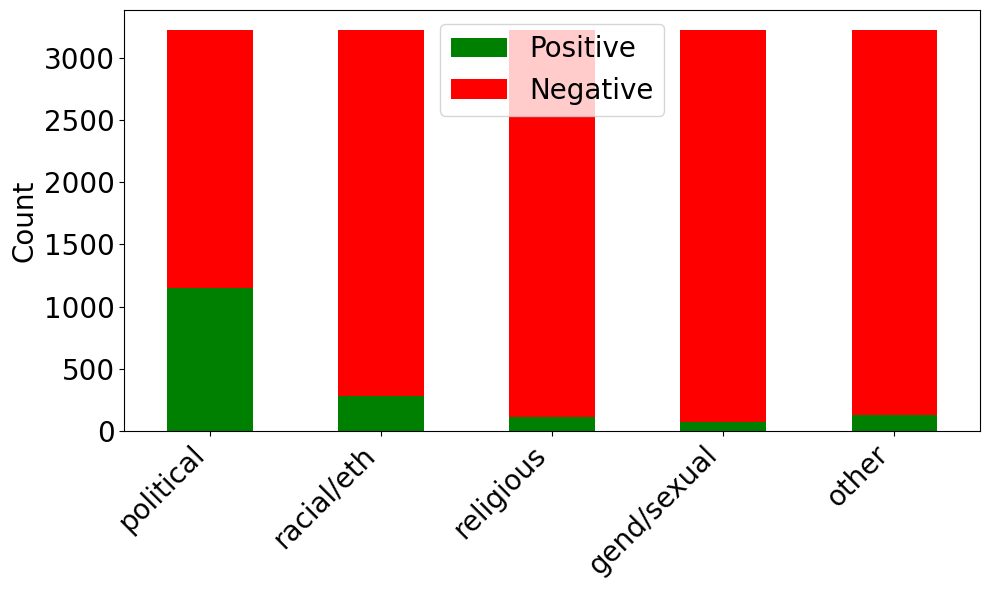

In [ ]:
# 5. Stacked bar for class imbalance visualization

imbalance_data = pd.DataFrame({
    'Positive': df[label_cols].sum(),
    'Negative': len(df) - df[label_cols].sum()
})

# Rename index for display (x-axis labels)
imbalance_data.index = ['political', 'racial/eth', 'religious', 'gend/sexual', 'other']

fig5, ax = plt.subplots(figsize=(10, 6))

imbalance_data.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],

    ax=ax
)

# Axis labels
ax.set_ylabel('Count', fontsize=AXIS_LABEL_SIZE)

# Tick label sizes and rotation
ax.set_xticklabels(
    ax.get_xticklabels(),
    fontsize=TICK_LABEL_SIZE,
    rotation=45,
    ha='right'
)
ax.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)

# Legend font size
ax.legend(fontsize=TICK_LABEL_SIZE)

plt.tight_layout()
plt.show()

# Save as PDF
fig5.savefig('subtask2_class_imbalance.pdf', format='pdf')


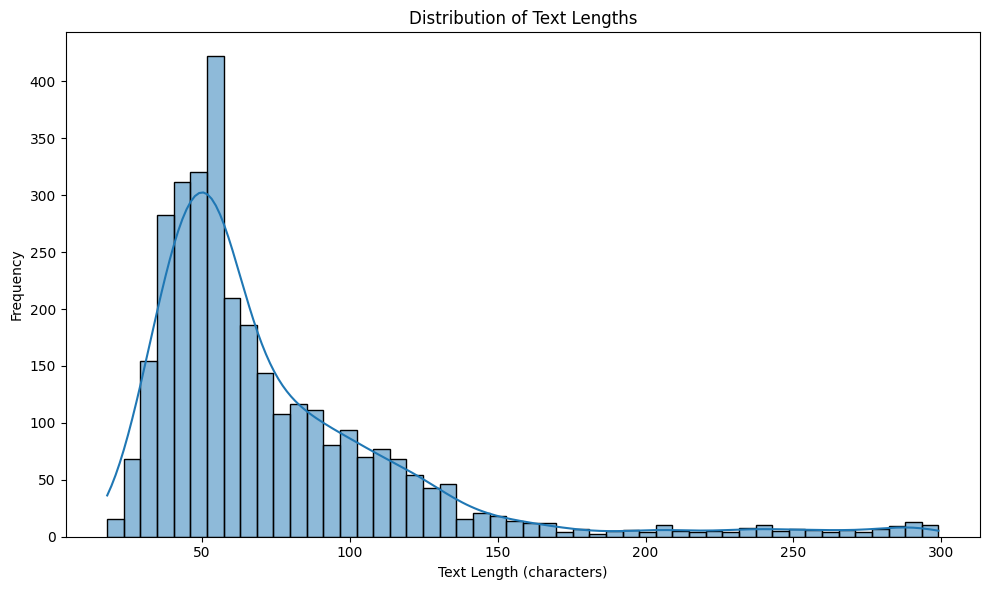

In [ ]:
# Additional: Text length distribution (for textual EDA)
df['text_length'] = df['text'].str.len()

fig6, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, ax=ax)
ax.set_title('Distribution of Text Lengths')
ax.set_xlabel('Text Length (characters)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Save as SVG
fig6.savefig('text_length_distribution.svg', format='svg')

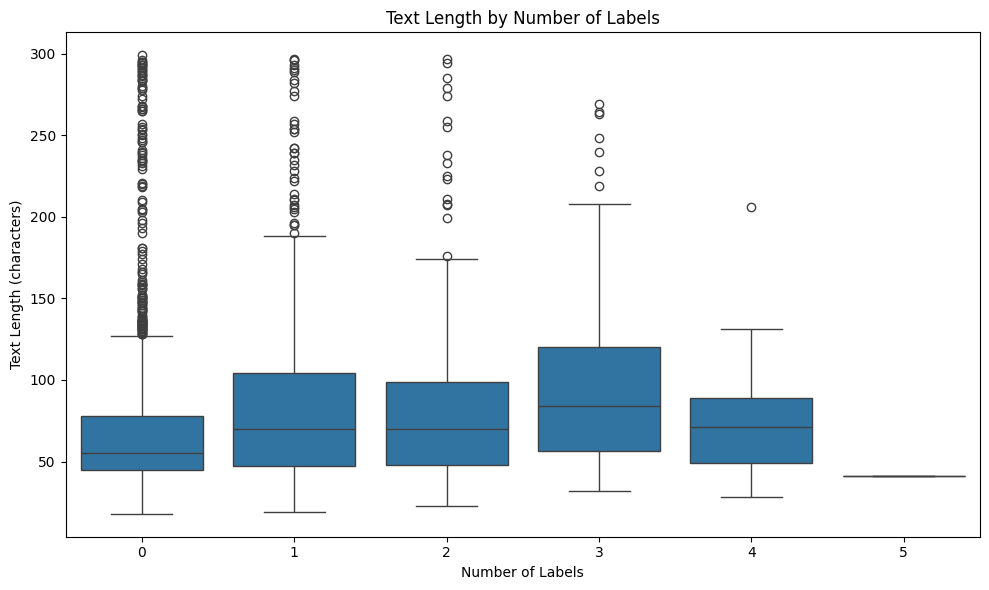

In [ ]:
# Additional: Boxplot of text lengths by number of labels
df['label_count'] = df[label_cols].sum(axis=1)

fig7, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='label_count', y='text_length', data=df, ax=ax)
ax.set_title('Text Length by Number of Labels')
ax.set_xlabel('Number of Labels')
ax.set_ylabel('Text Length (characters)')
plt.tight_layout()
plt.show()

# Save as SVG
fig7.savefig('text_length_by_labels.svg', format='svg')

In [ ]:
# import glob
# from google.colab import files

# # List all SVG files in the current directory
# svg_files = glob.glob('*.svg')

# # Download each one
# for svg in svg_files:
#     files.download(svg)

# print(f"Downloaded {len(svg_files)} SVG files.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded 7 SVG files.


# Subtask 3 Exploratory Data Exploration


In [ ]:
df  = pd.read_csv("/content/drive/MyDrive/polarization_dataset/subtask3/train/eng.csv")
print(df.head())

                                     id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  stereotype  \
0           is defending imperialism in the dnd chat           0   
1  Still playing with this. I am now following Ra...           0   
2  .senate.gov Theres 3 groups out there Republic...           0   
3  "ABC MD, David Anderson, said the additional f...           0   
4  "bad people" I have some conservative values s...           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0               0                 0   

In [ ]:
columns_to_drop = ['original_language', 'translated_from', 'label_count']
df_dropped = df.drop(columns=columns_to_drop)

In [ ]:
df = df_dropped

In [ ]:
df.to_csv("/content/drive/MyDrive/polarization_dataset/subtask3/train/eng_balanced.csv", index=False)
print(df.head())

                                     id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  stereotype  \
0           is defending imperialism in the dnd chat           0   
1  Still playing with this. I am now following Ra...           0   
2  .senate.gov Theres 3 groups out there Republic...           0   
3  "ABC MD, David Anderson, said the additional f...           0   
4  "bad people" I have some conservative values s...           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             0               0                 0   

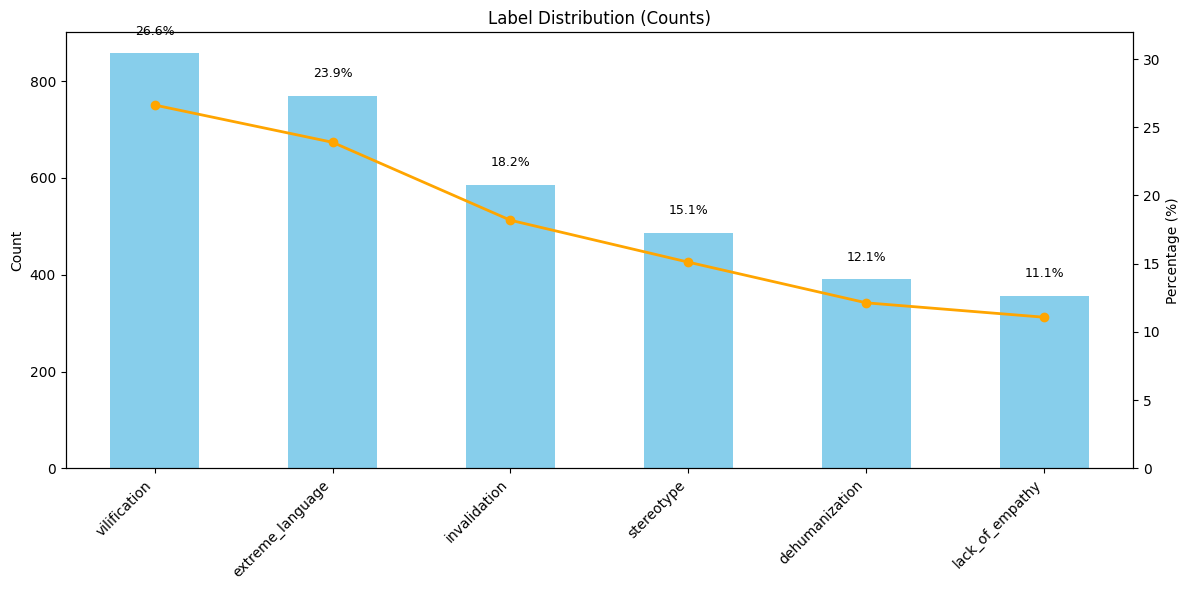

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files  # For downloading in Colab
import numpy as np

# Assuming df is already loaded; if not, uncomment the line below
# df = pd.read_csv("/path/to/your/new_dataset.csv")  # Update with your actual path

# Define the new label columns
label_cols = ['stereotype', 'vilification', 'dehumanization',
              'extreme_language', 'lack_of_empathy', 'invalidation']

# Ensure labels are numeric (in case they are strings)
df[label_cols] = df[label_cols].apply(pd.to_numeric, errors='coerce')

# 1. Bar chart for label distribution (counts and percentages)
label_counts = df[label_cols].sum().sort_values(ascending=False)
label_pcts = (label_counts / len(df)) * 100

fig1, ax1 = plt.subplots(figsize=(12, 6))
bars = label_counts.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('Label Distribution (Counts)')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add percentage labels on bars
for i, (count, pct) in enumerate(zip(label_counts, label_pcts)):
    ax1.text(i, count + (len(df) * 0.01), f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# Twin axis for line (optional, comment out if not needed)
ax2 = ax1.twinx()
label_pcts.plot(kind='line', color='orange', marker='o', ax=ax2, linewidth=2)
ax2.set_ylabel('Percentage (%)')
ax2.set_ylim(0, max(label_pcts) * 1.2)

plt.tight_layout()
plt.show()

# Save as SVG
# fig1.savefig('new_label_distribution.pdf', format='pdf')

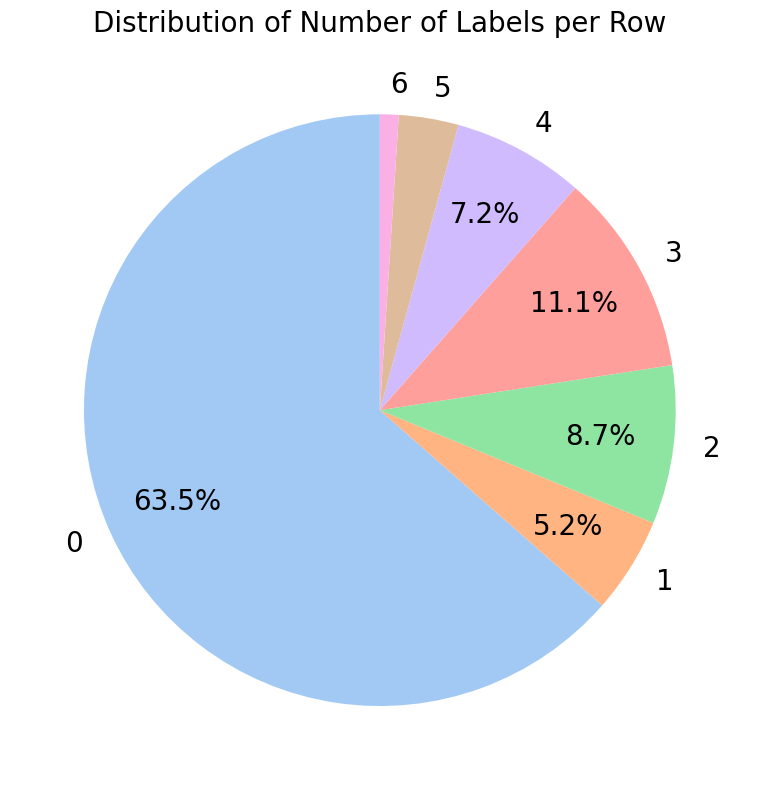

In [ ]:
# 2. Pie chart for multi-label count distribution
df['label_count'] = df[label_cols].sum(axis=1)
multi_label_counts = df['label_count'].value_counts().sort_index()

# Only show autopct for slices > threshold
def autopct_fmt(pct):
    return f'{pct:.1f}%' if pct >= 5 else ''  # hide very small slices

fig2, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    multi_label_counts,
    labels=multi_label_counts.index,
    autopct=autopct_fmt,
    startangle=90,
    colors=sns.color_palette('pastel'),
    textprops={'fontsize': TICK_LABEL_SIZE},
    pctdistance=0.75,   # move percentages slightly outward
    labeldistance=1.1   # move labels slightly further out
)

# Adjust font size for percentages explicitly
for autotext in autotexts:
    autotext.set_fontsize(TICK_LABEL_SIZE)

# Title
ax.set_title(
    'Distribution of Number of Labels per Row',
    fontsize=TITLE_SIZE
)

plt.tight_layout()
plt.show()

# Save as PDF
fig2.savefig('subtask3_label_cardinality.pdf', format='pdf')


In [ ]:
def get_multi_label_summary_df(df, label_cols):
    """
    Return a DataFrame with multi-label distribution summary
    """
    df['label_count'] = df[label_cols].sum(axis=1)
    multi_label_counts = df['label_count'].value_counts().sort_index()
    total = multi_label_counts.sum()

    summary_df = pd.DataFrame({
        'labels_count': multi_label_counts.index,
        'rows': multi_label_counts.values,
        'percentage': (multi_label_counts.values / total * 100).round(1)
    })

    # Add cumulative statistics
    summary_df['cumulative_rows'] = summary_df['rows'].cumsum()
    summary_df['cumulative_percentage'] = summary_df['percentage'].cumsum()

    return summary_df

# Usage
summary_df = get_multi_label_summary_df(df, label_cols)
print(summary_df)

   labels_count  rows  percentage  cumulative_rows  cumulative_percentage
0             0  3487        49.9             3487                   49.9
1             1   378         5.4             3865                   55.3
2             2   547         7.8             4412                   63.1
3             3   818        11.7             5230                   74.8
4             4   952        13.6             6182                   88.4
5             5   647         9.3             6829                   97.7
6             6   162         2.3             6991                  100.0


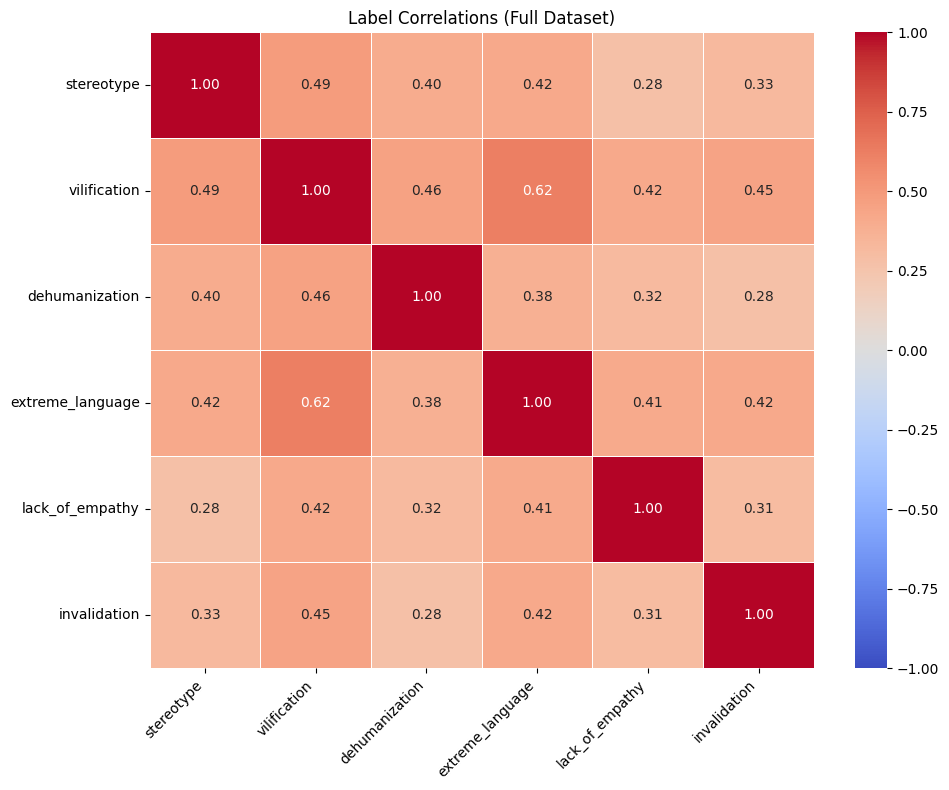

In [ ]:
# 3. Heatmap for label correlations (full dataset)
corr_matrix = df[label_cols].corr()

fig3, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax, fmt='.2f', linewidths=0.5)
ax.set_title('Label Correlations (Full Dataset)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Save as SVG
fig3.savefig('new_label_correlations_full.sg', format='svg')

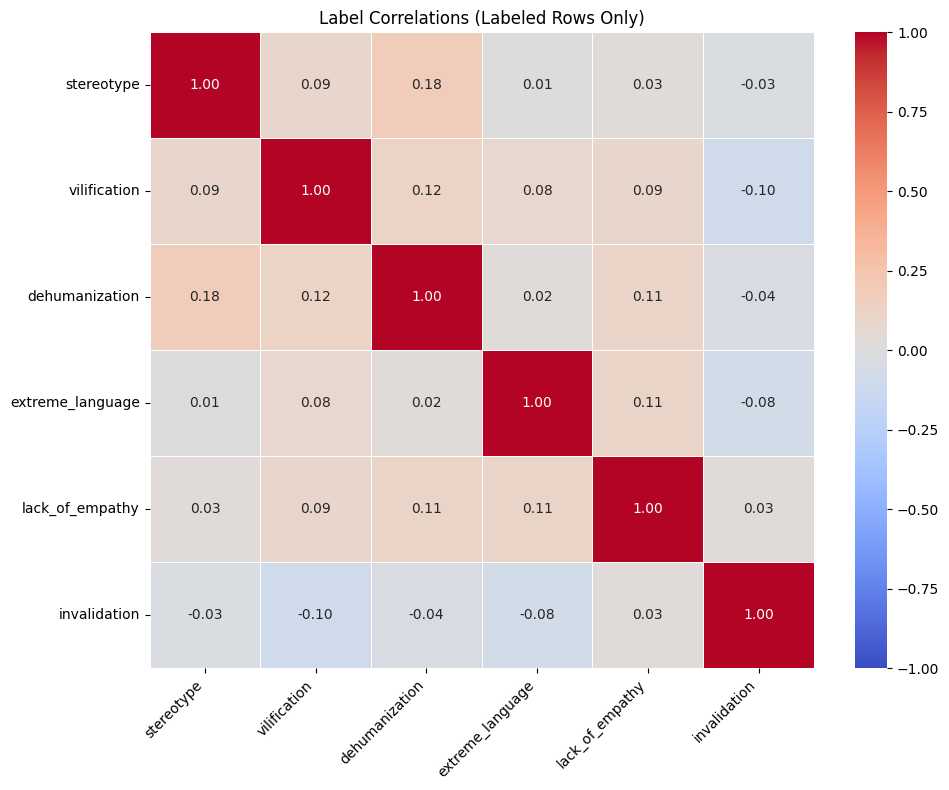

Original: 3222 rows | Labeled only: 1175 rows (36.5%)


In [ ]:
# 4. Filtered: Labeled rows only (exclude all-zero rows)
df_labeled = df[df[label_cols].sum(axis=1) > 0]
corr_matrix_labeled = df_labeled[label_cols].corr()

fig4, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_labeled, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax, fmt='.2f', linewidths=0.5)
ax.set_title('Label Correlations (Labeled Rows Only)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Save as SVG
fig4.savefig('new_label_correlations_labeled.svg', format='svg')

print(f"Original: {len(df)} rows | Labeled only: {len(df_labeled)} rows ({len(df_labeled)/len(df)*100:.1f}%)")

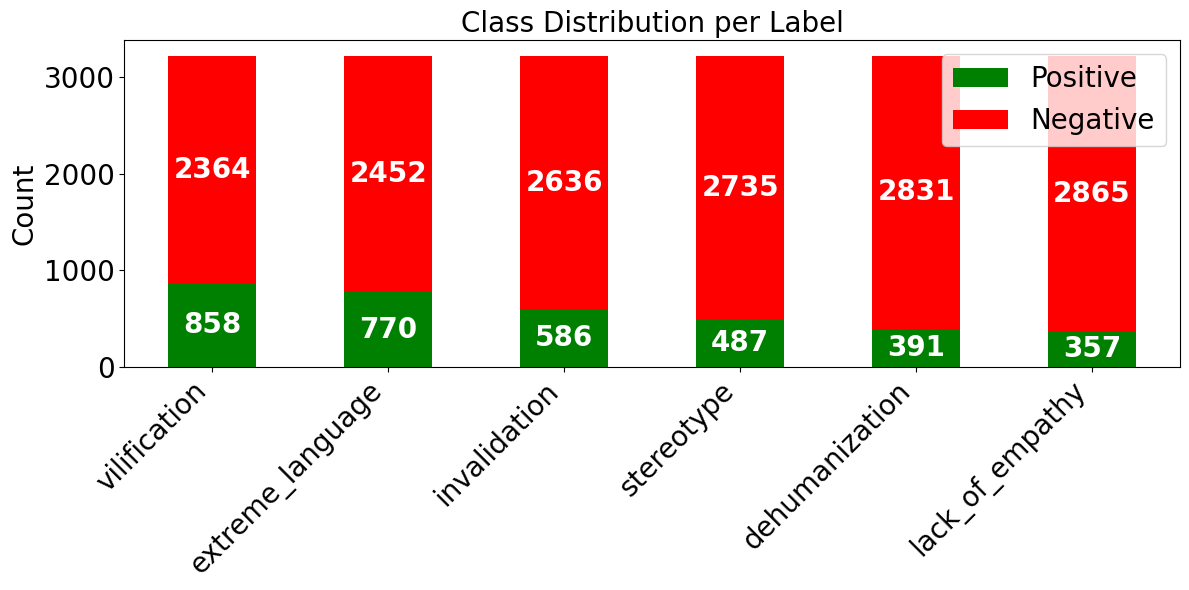

In [ ]:
# 5. Stacked bar for class imbalance
imbalance_data = pd.DataFrame({
    'Positive': df[label_cols].sum(),
    'Negative': len(df) - df[label_cols].sum()
}).sort_values('Positive', ascending=False)

fig5, ax = plt.subplots(figsize=(12, 6))

imbalance_data.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],
    ax=ax
)

# Title and axis labels
ax.set_title('Class Distribution per Label', fontsize=TITLE_SIZE)
ax.set_ylabel('Count', fontsize=AXIS_LABEL_SIZE)

# Tick label sizes and rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=TICK_LABEL_SIZE)
ax.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)

# Legend font size
ax.legend(fontsize=TICK_LABEL_SIZE)

# Add count labels inside bars
for i, (pos, neg) in enumerate(zip(imbalance_data['Positive'], imbalance_data['Negative'])):
    ax.text(i, pos / 2, str(int(pos)),
            ha='center', va='center', color='white',
            fontweight='bold', fontsize=TICK_LABEL_SIZE)
    ax.text(i, pos + neg / 2, str(int(neg)),
            ha='center', va='center', color='white',
            fontweight='bold', fontsize=TICK_LABEL_SIZE)

plt.tight_layout()
plt.show()

# Save as PDF
fig5.savefig('subtask3_manifestation_distribution.pdf', format='pdf')


stereotype: 487 positives | Imbalance ratio ~5.6:1 (neg:pos)
vilification: 858 positives | Imbalance ratio ~2.8:1 (neg:pos)
dehumanization: 391 positives | Imbalance ratio ~7.2:1 (neg:pos)
extreme_language: 770 positives | Imbalance ratio ~3.2:1 (neg:pos)
lack_of_empathy: 357 positives | Imbalance ratio ~8.0:1 (neg:pos)
invalidation: 586 positives | Imbalance ratio ~4.5:1 (neg:pos)


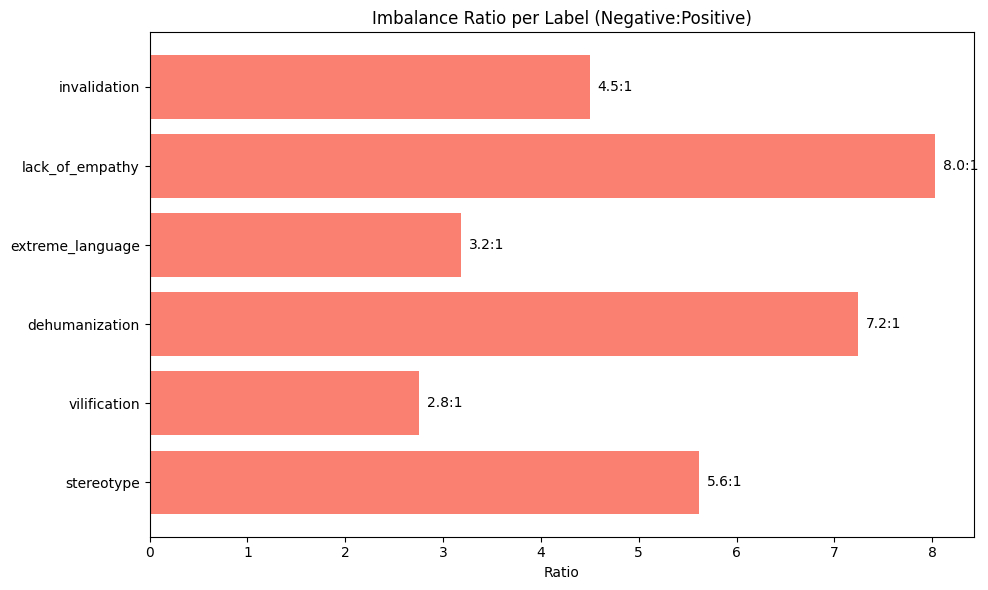

In [ ]:
# 6. Imbalance ratios (print + optional bar)
total = len(df)
ratios = []
for col in label_cols:
    pos = df[col].sum()
    neg = total - pos
    ratio = neg / pos if pos > 0 else float('inf')
    ratios.append(ratio)
    print(f"{col}: {pos} positives | Imbalance ratio ~{ratio:.1f}:1 (neg:pos)")

# Optional: Bar plot of ratios
fig6, ax = plt.subplots(figsize=(10, 6))
ax.barh([col for col in label_cols], ratios, color='salmon')
ax.set_title('Imbalance Ratio per Label (Negative:Positive)')
ax.set_xlabel('Ratio')
for i, r in enumerate(ratios):
    ax.text(r + max(ratios)*0.01, i, f'{r:.1f}:1', va='center')

plt.tight_layout()
plt.show()

# Save as SVG
fig6.savefig('new_imbalance_ratios.svg', format='svg')


--- Label Counts ---
vilification        858
extreme_language    770
invalidation        586
stereotype          487
dehumanization      391
lack_of_empathy     357
dtype: int64


/tmp/ipython-input-1850656065.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')


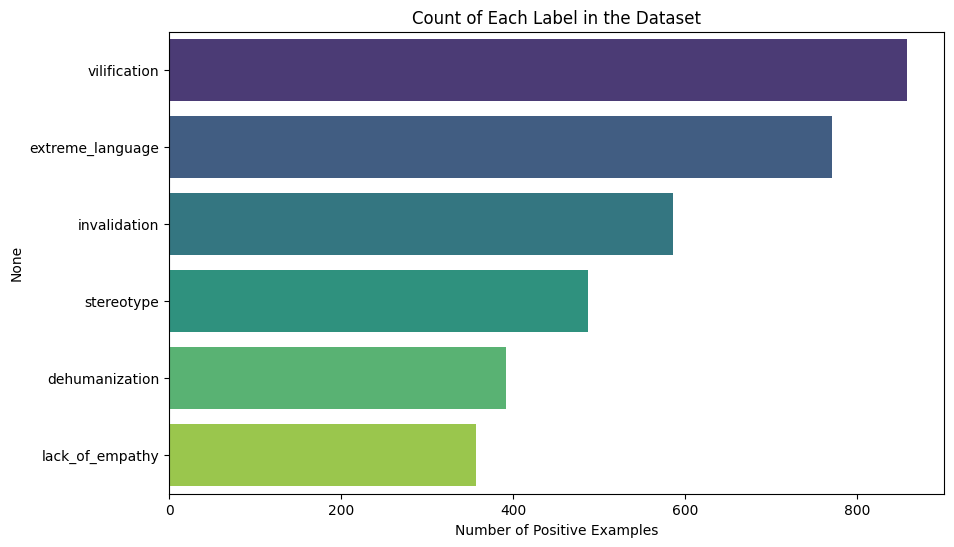

In [ ]:
# List of your specific label columns
label_cols = ['stereotype', 'vilification', 'dehumanization',
              'extreme_language', 'lack_of_empathy', 'invalidation']

# Sum up the "1"s for each column
label_counts = df[label_cols].sum().sort_values(ascending=False)

print("\n--- Label Counts ---")
print(label_counts)

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.title('Count of Each Label in the Dataset')
plt.xlabel('Number of Positive Examples')
plt.savefig("label_count.svg", format="svg")
plt.show()

In [ ]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00


Loading datasets...
Original English dataset: 3222 rows
Swahili dataset: 6991 rows

=== ORIGINAL ENGLISH DATASET STATISTICS ===
 labels_count  rows  percentage  cumulative_rows  cumulative_percentage
            0  2047        63.5             2047                   63.5
            1   169         5.2             2216                   68.7
            2   279         8.7             2495                   77.4
            3   357        11.1             2852                   88.5
            4   232         7.2             3084                   95.7
            5   105         3.3             3189                   99.0
            6    33         1.0             3222                  100.0

=== BALANCING DATASET ===
Target count for each label_count (>=1): 952
Adding 378 rows with label_count=1
Adding 547 rows with label_count=2
Adding 595 rows with label_count=3
Adding 720 rows with label_count=4
Adding 647 rows with label_count=5
Adding 162 rows with label_count=6

Added 3049 tr

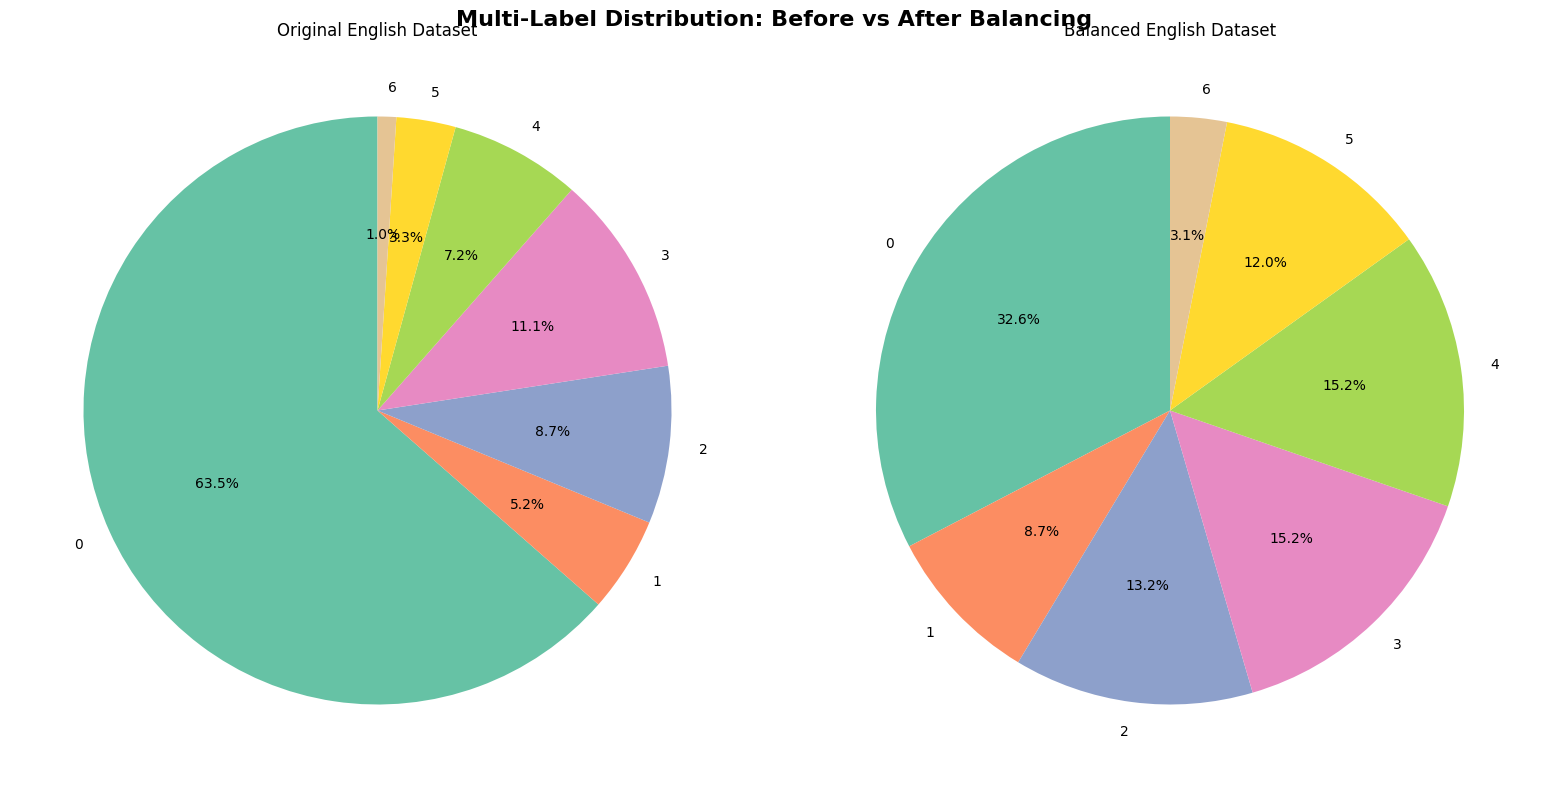


Balanced dataset saved to: eng_balanced.csv
Visualization saved to: balancing_comparison.png

=== DOWNLOAD OPTIONS ===
1. Download balanced dataset:
   !cp 'eng_balanced.csv' '/content/'

2. Download visualization:
   !cp 'balancing_comparison.png' '/content/'

3. Download both:
   !cp 'eng_balanced.csv' 'balancing_comparison.png' '/content/'

4. Download zip file with both:
   !cp 'balancing_results.zip' '/content/'

=== IMPROVEMENT SUMMARY ===
Label count 1: 169 → 547 rows (+223.7%)
Label count 2: 279 → 826 rows (+196.1%)
Label count 3: 357 → 952 rows (+166.7%)
Label count 4: 232 → 952 rows (+310.3%)
Label count 5: 105 → 752 rows (+616.2%)
Label count 6: 33 → 195 rows (+490.9%)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
import time
import os

# Set up translation
from deep_translator import GoogleTranslator

def translate_text(text, src_lang='sw', dest_lang='en', max_retries=3):
    """
    Translate text from Swahili to English using deep-translator
    """
    for attempt in range(max_retries):
        try:
            translator = GoogleTranslator(source=src_lang, target=dest_lang)
            translation = translator.translate(text)
            return translation
        except Exception as e:
            print(f"Translation attempt {attempt + 1} failed: {e}")
            time.sleep(2)  # Wait before retry
    return text  # Return original if all retries fail
def calculate_label_counts(df):
    """
    Calculate label count for each row and return distribution stats
    """
    label_cols = ['stereotype', 'vilification', 'dehumanization',
                  'extreme_language', 'lack_of_empathy', 'invalidation']

    df['label_count'] = df[label_cols].sum(axis=1)
    return df

def get_distribution_stats(df):
    """
    Get distribution statistics for label counts
    """
    distribution = df['label_count'].value_counts().sort_index()
    total = len(df)

    stats_df = pd.DataFrame({
        'labels_count': distribution.index,
        'rows': distribution.values,
        'percentage': (distribution.values / total * 100).round(1)
    })

    stats_df['cumulative_rows'] = stats_df['rows'].cumsum()
    stats_df['cumulative_percentage'] = stats_df['percentage'].cumsum().round(1)

    return stats_df

def balance_datasets(eng_df, swa_df, target_counts='uniform'):
    """
    Balance English dataset using Swahili dataset
    target_counts: 'uniform' to make all counts equal, or specify custom target
    """
    # Calculate label counts for both datasets
    eng_df = calculate_label_counts(eng_df)
    swa_df = calculate_label_counts(swa_df)

    # Get current distributions
    eng_dist = eng_df['label_count'].value_counts().sort_index()
    swa_dist = swa_df['label_count'].value_counts().sort_index()

    # Determine target counts
    if target_counts == 'uniform':
        # Target is the maximum count among label_count >= 1
        target_count = max(eng_dist[eng_dist.index >= 1].max(),
                          swa_dist[swa_dist.index >= 1].max())
    else:
        target_count = target_counts

    print(f"Target count for each label_count (>=1): {target_count}")

    # Collect rows to add
    rows_to_add = []

    # For each label_count from 1 to 6
    for label_count in range(1, 7):
        current_count = eng_dist.get(label_count, 0)
        needed = max(0, target_count - current_count)

        if needed > 0:
            # Get Swahili rows with this label_count
            swa_rows = swa_df[swa_df['label_count'] == label_count].copy()

            # Take only as many as needed
            if len(swa_rows) > needed:
                swa_rows = swa_rows.sample(needed, random_state=42)

            print(f"Adding {len(swa_rows)} rows with label_count={label_count}")

            # Translate and prepare rows
            for idx, row in swa_rows.iterrows():
                translated_text = translate_text(row['text'])

                new_row = {
                    'id': f"swa_translated_{row['id']}",
                    'text': translated_text,
                    'stereotype': row['stereotype'],
                    'vilification': row['vilification'],
                    'dehumanization': row['dehumanization'],
                    'extreme_language': row['extreme_language'],
                    'lack_of_empathy': row['lack_of_empathy'],
                    'invalidation': row['invalidation'],
                    'label_count': row['label_count'],
                    'original_language': 'sw',
                    'translated_from': row['id']
                }
                rows_to_add.append(new_row)

    # Create DataFrame from new rows
    if rows_to_add:
        new_rows_df = pd.DataFrame(rows_to_add)
        # Combine with original English data
        balanced_df = pd.concat([eng_df, new_rows_df], ignore_index=True)
    else:
        balanced_df = eng_df.copy()

    # Recalculate label counts for the balanced dataset
    balanced_df = calculate_label_counts(balanced_df)

    return balanced_df, len(rows_to_add)

def create_pie_chart_comparison(original_stats, balanced_stats, title="Label Distribution Comparison"):
    """
    Create a comparison pie chart showing before and after distributions
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Colors for pie chart
    colors = sns.color_palette('Set2', len(original_stats))

    # Original distribution
    axes[0].pie(original_stats['rows'], labels=original_stats['labels_count'].astype(str),
                autopct='%1.1f%%', startangle=90, colors=colors)
    axes[0].set_title('Original English Dataset')

    # Balanced distribution
    axes[1].pie(balanced_stats['rows'], labels=balanced_stats['labels_count'].astype(str),
                autopct='%1.1f%%', startangle=90, colors=colors)
    axes[1].set_title('Balanced English Dataset')

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    return fig

def main():
    # File paths
    eng_path = '/content/drive/MyDrive/polarization_dataset/subtask3/train/eng.csv'
    swa_path = '/content/drive/MyDrive/polarization_dataset/subtask3/train/swa.csv'

    # Load datasets
    print("Loading datasets...")
    eng_df = pd.read_csv(eng_path)
    swa_df = pd.read_csv(swa_path)

    print(f"Original English dataset: {len(eng_df)} rows")
    print(f"Swahili dataset: {len(swa_df)} rows")

    # Calculate original statistics
    eng_df = calculate_label_counts(eng_df)
    original_stats = get_distribution_stats(eng_df)

    print("\n=== ORIGINAL ENGLISH DATASET STATISTICS ===")
    print(original_stats.to_string(index=False))

    # Balance the dataset
    print("\n=== BALANCING DATASET ===")
    balanced_df, rows_added = balance_datasets(eng_df, swa_df, target_counts='uniform')

    print(f"\nAdded {rows_added} translated rows from Swahili dataset")
    print(f"Balanced dataset: {len(balanced_df)} rows")

    # Calculate balanced statistics
    balanced_stats = get_distribution_stats(balanced_df)

    print("\n=== BALANCED ENGLISH DATASET STATISTICS ===")
    print(balanced_stats.to_string(index=False))

    # Create visualization
    print("\n=== CREATING VISUALIZATION ===")
    fig = create_pie_chart_comparison(
        original_stats,
        balanced_stats,
        title="Multi-Label Distribution: Before vs After Balancing"
    )

    # Display the chart
    plt.show()

    # Save the balanced dataset
    output_path = 'eng_balanced.csv'
    balanced_df.to_csv(output_path, index=False)
    print(f"\nBalanced dataset saved to: {output_path}")

    # Save visualization
    viz_path = 'balancing_comparison.png'
    fig.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to: {viz_path}")

    # Provide download options
    print("\n=== DOWNLOAD OPTIONS ===")
    print("1. Download balanced dataset:")
    print(f"   !cp '{output_path}' '/content/'")
    print("\n2. Download visualization:")
    print(f"   !cp '{viz_path}' '/content/'")
    print("\n3. Download both:")
    print(f"   !cp '{output_path}' '{viz_path}' '/content/'")

    # Alternative: Create a downloadable zip
    import zipfile
    zip_path = 'balancing_results.zip'
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        zipf.write(output_path, os.path.basename(output_path))
        zipf.write(viz_path, os.path.basename(viz_path))

    print(f"\n4. Download zip file with both:")
    print(f"   !cp '{zip_path}' '/content/'")

    # Calculate improvement statistics
    print("\n=== IMPROVEMENT SUMMARY ===")
    for i in range(1, 7):
        orig = original_stats[original_stats['labels_count'] == i]['rows'].values
        bal = balanced_stats[balanced_stats['labels_count'] == i]['rows'].values

        if len(orig) > 0 and len(bal) > 0:
            improvement = ((bal[0] - orig[0]) / orig[0] * 100) if orig[0] > 0 else 100
            print(f"Label count {i}: {orig[0]} → {bal[0]} rows (+{improvement:.1f}%)")

    return balanced_df, fig

# Run the main function
if __name__ == "__main__":
    balanced_df, fig = main()

SWAHILI DATASET BALANCING SCRIPT
Goal: Balance Swahili dataset using translated English rows
Translation: English → Swahili
Loading datasets...
Original Swahili dataset: 6991 rows
English dataset (source): 3222 rows

ORIGINAL SWAHILI DATASET STATISTICS
 labels_count  rows  percentage  cumulative_rows  cumulative_percentage
            0  3487        49.9             3487                   49.9
            1   378         5.4             3865                   55.3
            2   547         7.8             4412                   63.1
            3   818        11.7             5230                   74.8
            4   952        13.6             6182                   88.4
            5   647         9.3             6829                   97.7
            6   162         2.3             6991                  100.0

BALANCING SWAHILI DATASET
Target count for each label_count (>=1) in Swahili: 952

Current Swahili distribution (>=1):
  Label count 1: 378 rows
  Label count 2: 547 rows

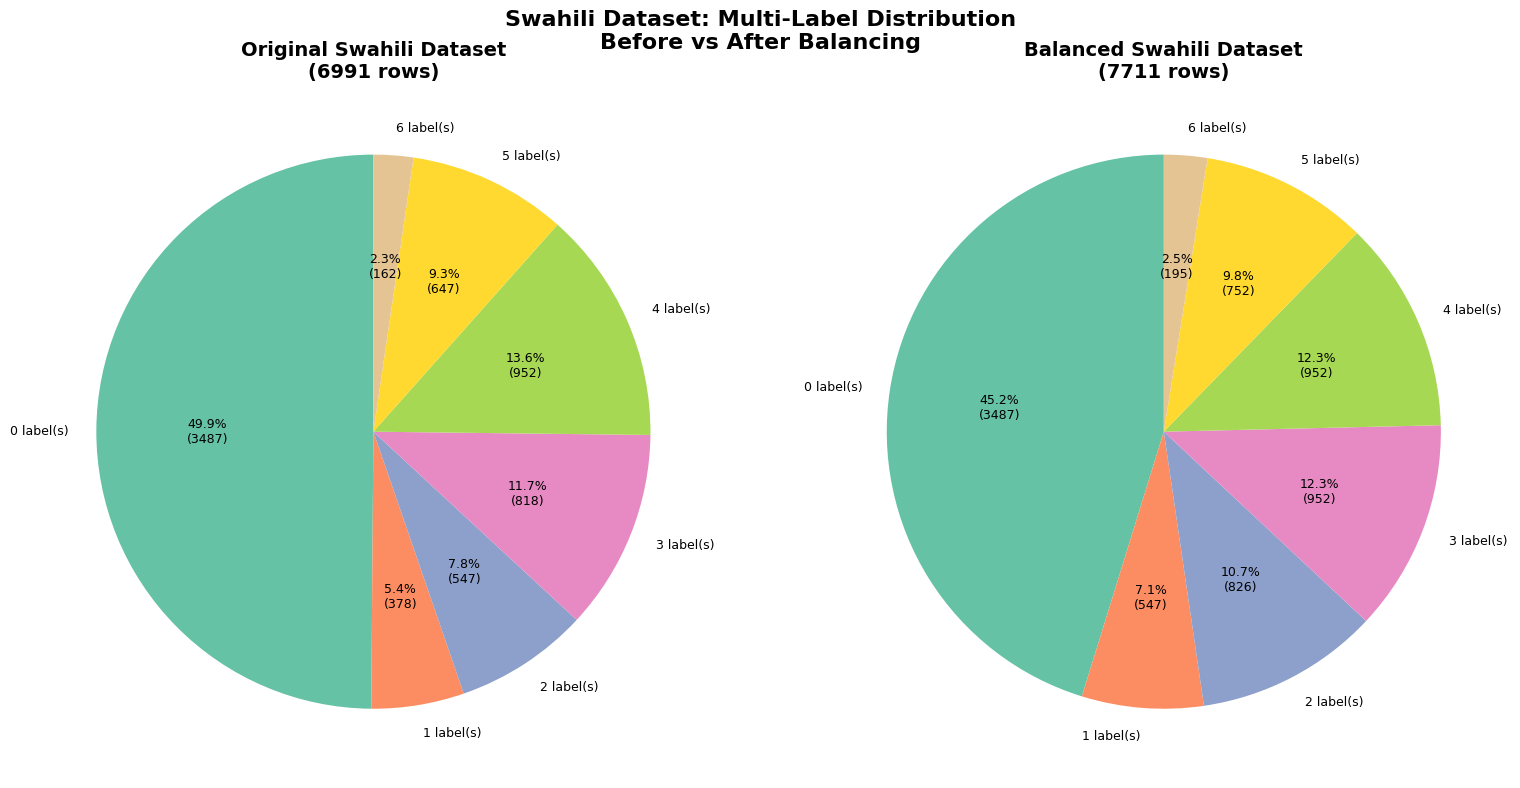


IMPROVEMENT SUMMARY
Label count 2:  547 →  826 rows (+51.0%)
Label count 1:  378 →  547 rows (+44.7%)
Label count 6:  162 →  195 rows (+20.4%)
Label count 3:  818 →  952 rows (+16.4%)
Label count 5:  647 →  752 rows (+16.2%)
Label count 4:  952 →  952 rows (+0.0%)

Overall Statistics:
Total rows added: 720
Original total: 6991
Balanced total: 7711
Growth: 10.3%

DOWNLOAD OPTIONS

1. Download balanced Swahili dataset:
from google.colab import files
files.download('/content/drive/MyDrive/polarization_dataset/subtask3/train/swa_balanced.csv')

2. Download visualization:
files.download('/content/drive/MyDrive/polarization_dataset/subtask3/train/swahili_balancing_comparison.png')

3. Download both as ZIP:
import zipfile
zip_path = '/content/swahili_balancing_results.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write('/content/drive/MyDrive/polarization_dataset/subtask3/train/swa_balanced.csv', 'swa_balanced.csv')
    zipf.write('/content/drive/MyDrive/polarization_dataset/sub

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from deep_translator import GoogleTranslator

def translate_text(text, src_lang='en', dest_lang='sw', max_retries=3):
    """
    Translate text from English to Swahili with retry logic
    """
    for attempt in range(max_retries):
        try:
            translator = GoogleTranslator(source=src_lang, target=dest_lang)
            translation = translator.translate(text)
            return translation
        except Exception as e:
            print(f"Translation attempt {attempt + 1} failed: {e}")
            time.sleep(2)  # Wait before retry
    return text  # Return original if all retries fail

def calculate_label_counts(df):
    """Calculate label count for each row"""
    label_cols = ['stereotype', 'vilification', 'dehumanization',
                  'extreme_language', 'lack_of_empathy', 'invalidation']
    df['label_count'] = df[label_cols].sum(axis=1)
    return df

def get_distribution_stats(df):
    """Get distribution statistics for label counts"""
    distribution = df['label_count'].value_counts().sort_index()
    total = len(df)

    stats_df = pd.DataFrame({
        'labels_count': distribution.index,
        'rows': distribution.values,
        'percentage': (distribution.values / total * 100).round(1)
    })

    stats_df['cumulative_rows'] = stats_df['rows'].cumsum()
    stats_df['cumulative_percentage'] = stats_df['percentage'].cumsum().round(1)

    return stats_df

def balance_swahili_dataset(swa_df, eng_df, target_counts='uniform'):
    """
    Balance Swahili dataset using English dataset
    target_counts: 'uniform' to make all counts equal, or specify custom target
    """
    # Calculate label counts for both datasets
    swa_df = calculate_label_counts(swa_df)
    eng_df = calculate_label_counts(eng_df)

    # Get current distributions
    swa_dist = swa_df['label_count'].value_counts().sort_index()
    eng_dist = eng_df['label_count'].value_counts().sort_index()

    # Determine target counts
    if target_counts == 'uniform':
        # Target is the maximum count among label_count >= 1 in Swahili
        swa_counts = swa_dist[swa_dist.index >= 1]
        target_count = swa_counts.max() if len(swa_counts) > 0 else 0
    else:
        target_count = target_counts

    print(f"Target count for each label_count (>=1) in Swahili: {target_count}")
    print(f"\nCurrent Swahili distribution (>=1):")
    for label in range(1, 7):
        count = swa_dist.get(label, 0)
        print(f"  Label count {label}: {count} rows")

    # Collect rows to add
    rows_to_add = []

    # For each label_count from 1 to 6
    for label_count in range(1, 7):
        current_count = swa_dist.get(label_count, 0)
        needed = max(0, target_count - current_count)

        if needed > 0:
            # Get English rows with this label_count
            eng_rows = eng_df[eng_df['label_count'] == label_count].copy()

            # Take only as many as needed
            if len(eng_rows) > needed:
                eng_rows = eng_rows.sample(needed, random_state=42)

            print(f"\nAdding {len(eng_rows)} rows with label_count={label_count}")

            # Translate and prepare rows
            for idx, row in eng_rows.iterrows():
                try:
                    translated_text = translate_text(row['text'], src_lang='en', dest_lang='sw')

                    new_row = {
                        'id': f"eng_translated_{row['id']}",
                        'text': translated_text,
                        'stereotype': row['stereotype'],
                        'vilification': row['vilification'],
                        'dehumanization': row['dehumanization'],
                        'extreme_language': row['extreme_language'],
                        'lack_of_empathy': row['lack_of_empathy'],
                        'invalidation': row['invalidation'],
                        'label_count': row['label_count'],
                        'original_language': 'en',
                        'translated_from': row['id']
                    }
                    rows_to_add.append(new_row)

                    # Show progress
                    if len(rows_to_add) % 50 == 0:
                        print(f"  Translated {len(rows_to_add)} rows so far...")

                except Exception as e:
                    print(f"  Error translating row {row['id']}: {e}")
                    continue

    # Create DataFrame from new rows
    if rows_to_add:
        new_rows_df = pd.DataFrame(rows_to_add)
        # Combine with original Swahili data
        balanced_df = pd.concat([swa_df, new_rows_df], ignore_index=True)
    else:
        balanced_df = swa_df.copy()

    # Recalculate label counts for the balanced dataset
    balanced_df = calculate_label_counts(balanced_df)

    return balanced_df, len(rows_to_add)

def create_visualization(original_stats, balanced_stats, dataset_name="Swahili"):
    """Create and save visualization"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Colors for pie chart
    colors = sns.color_palette('Set2', len(original_stats))

    # Original distribution
    axes[0].pie(original_stats['rows'],
                labels=original_stats['labels_count'].astype(str) + ' label(s)',
                autopct=lambda p: f'{p:.1f}%\n({int(p/100*sum(original_stats["rows"]))})',
                startangle=90,
                colors=colors,
                textprops={'fontsize': 9})
    axes[0].set_title(f'Original {dataset_name} Dataset\n({sum(original_stats["rows"])} rows)',
                     fontsize=14, fontweight='bold')

    # Balanced distribution
    axes[1].pie(balanced_stats['rows'],
                labels=balanced_stats['labels_count'].astype(str) + ' label(s)',
                autopct=lambda p: f'{p:.1f}%\n({int(p/100*sum(balanced_stats["rows"]))})',
                startangle=90,
                colors=colors,
                textprops={'fontsize': 9})
    axes[1].set_title(f'Balanced {dataset_name} Dataset\n({sum(balanced_stats["rows"])} rows)',
                     fontsize=14, fontweight='bold')

    fig.suptitle(f'{dataset_name} Dataset: Multi-Label Distribution\nBefore vs After Balancing',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save visualization
    viz_path = f'/content/drive/MyDrive/polarization_dataset/subtask3/train/{dataset_name.lower()}_balancing_comparison.png'
    fig.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved to: {viz_path}")

    # Show plot
    plt.show()

    return fig, viz_path

def main():
    # File paths - UPDATE THESE!
    swa_path = '/content/drive/MyDrive/polarization_dataset/subtask3/train/swa.csv'
    eng_path = '/content/drive/MyDrive/polarization_dataset/subtask3/train/eng.csv'  # UPDATED

    print("Loading datasets...")
    swa_df = pd.read_csv(swa_path)
    eng_df = pd.read_csv(eng_path)

    print(f"Original Swahili dataset: {len(swa_df)} rows")
    print(f"English dataset (source): {len(eng_df)} rows")

    # Calculate original statistics for Swahili
    swa_df = calculate_label_counts(swa_df)
    original_stats = get_distribution_stats(swa_df)

    print("\n" + "="*60)
    print("ORIGINAL SWAHILI DATASET STATISTICS")
    print("="*60)
    print(original_stats.to_string(index=False))

    # Balance the Swahili dataset
    print("\n" + "="*60)
    print("BALANCING SWAHILI DATASET")
    print("="*60)
    balanced_df, rows_added = balance_swahili_dataset(swa_df, eng_df, target_counts='uniform')

    print(f"\n✓ Added {rows_added} translated rows from English dataset")
    print(f"✓ Balanced Swahili dataset: {len(balanced_df)} rows")

    # Calculate balanced statistics
    balanced_stats = get_distribution_stats(balanced_df)

    print("\n" + "="*60)
    print("BALANCED SWAHILI DATASET STATISTICS")
    print("="*60)
    print(balanced_stats.to_string(index=False))

    # Save the balanced dataset
    output_path = '/content/drive/MyDrive/polarization_dataset/subtask3/train/swa_balanced.csv'
    balanced_df.to_csv(output_path, index=False)
    print(f"\n✓ Balanced dataset saved to: {output_path}")

    # Create and save visualization
    fig, viz_path = create_visualization(original_stats, balanced_stats, "Swahili")

    # Calculate and show improvement statistics
    print("\n" + "="*60)
    print("IMPROVEMENT SUMMARY")
    print("="*60)
    improvements = []

    for i in range(1, 7):
        orig = original_stats[original_stats['labels_count'] == i]
        bal = balanced_stats[balanced_stats['labels_count'] == i]

        if len(orig) > 0 and len(bal) > 0:
            orig_count = orig['rows'].values[0]
            bal_count = bal['rows'].values[0]
            if orig_count > 0:
                improvement_pct = ((bal_count - orig_count) / orig_count * 100)
            else:
                improvement_pct = 100
            improvements.append((i, orig_count, bal_count, improvement_pct))

    # Sort by improvement percentage
    improvements.sort(key=lambda x: x[3], reverse=True)

    for label_count, orig, bal, pct in improvements:
        print(f"Label count {label_count}: {orig:4d} → {bal:4d} rows ({pct:+.1f}%)")

    # Overall statistics
    print("\nOverall Statistics:")
    print(f"Total rows added: {rows_added}")
    print(f"Original total: {len(swa_df)}")
    print(f"Balanced total: {len(balanced_df)}")
    print(f"Growth: {((len(balanced_df) - len(swa_df)) / len(swa_df) * 100):.1f}%")

    # Provide download options
    print("\n" + "="*60)
    print("DOWNLOAD OPTIONS")
    print("="*60)
    print("\n1. Download balanced Swahili dataset:")
    print(f"""from google.colab import files
files.download('{output_path}')""")

    print("\n2. Download visualization:")
    print(f"""files.download('{viz_path}')""")

    print("\n3. Download both as ZIP:")
    print(f"""import zipfile
zip_path = '/content/swahili_balancing_results.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write('{output_path}', 'swa_balanced.csv')
    zipf.write('{viz_path}', 'balancing_comparison.png')
files.download(zip_path)""")

    return balanced_df, fig

# Run the main function
if __name__ == "__main__":
    print("SWAHILI DATASET BALANCING SCRIPT")
    print("="*60)
    print("Goal: Balance Swahili dataset using translated English rows")
    print("Translation: English → Swahili")
    print("="*60)

    balanced_df, fig = main()

In [ ]:
!nvidia-smi

Tue Dec 16 15:42:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----